In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import auc,make_scorer,classification_report, matthews_corrcoef,accuracy_score, average_precision_score, roc_auc_score,roc_curve,precision_recall_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from inspect import signature
from scipy import interp

In [6]:
def ANN():
    df_train = pd.read_csv('../Data/train.csv')
    df_test = pd.read_csv('../Data/validation.csv')
    
    df_test_under = pd.read_csv('../Data/validation_under.csv')
    
    # preprocessing data    
    df_train_data = df_train.drop(columns = ['Amount','Class'])
    df_train_result = df_train['Class']
    df_train_result = to_categorical(df_train_result)
    
    df_test_data = df_test.drop(columns = ['Amount','Class'])
    df_test_result = df_test['Class']
    
    df_test_under_data = df_test_under.drop(columns = ['Amount','Class'])
    df_test_under_result = df_test_under['Class']


    df_test_result = to_categorical(df_test_result)
    epochs = 500
    #create ANN model
    model = Sequential([
        Dense(64, kernel_initializer='glorot_normal',
                bias_initializer='zeros',input_shape=(16,),activation = 'relu'),
        Dropout(0.4),
        Dense(64,  kernel_initializer='glorot_normal',
                bias_initializer='zeros', activation='relu'),
        Dropout(0.4),
        Dense(64,  kernel_initializer='glorot_normal',
                bias_initializer='zeros',activation='relu'),
        Dropout(0.4),
        Dense(64,  kernel_initializer='glorot_normal',
                bias_initializer='zeros',activation='relu'),
        Dropout(0.4),
        Dense(2,activation='softmax')
        ])
    
    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy']
        )
    epoch = epochs   # should be 450 - 500
    batch_size = 2048
    model.fit(df_train_data,df_train_result,epochs = epoch, batch_size = batch_size)
    
    #prediction
    df_test_pred = model.predict(df_test_data)
    pred = np.argmax(df_test_pred, axis=1).tolist()
    print('CLASSIFICATION REPORT')
    df_test_report = df_test['Class'].tolist()
    print(classification_report(df_test_report, pred))
    
    #undersample prediction
    df_test_under_pred = model.predict(df_test_under_data)
    pred_under = np.argmax(df_test_under_pred, axis=1).tolist()
    print('CLASSIFICATION REPORT')
    df_test_under_report = df_test_under['Class'].tolist()
    print(classification_report(df_test_under_report, pred_under))
    
    #data transformation to roc curve
    df_test_under_roc= df_test_under['Class'].to_numpy().reshape(-1, 1)
    pred_under_roc = np.array(pred_under).reshape(-1, 1)
   
    
    #roc curve with cross-validation
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    cv = StratifiedKFold(n_splits=6)
    for train, test in cv.split(df_test_under_data, df_test_under_result):
    # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(df_test_under_roc[test], pred_under_roc[test], pos_label=1)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    #pr curve
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    precision, recall, _ = precision_recall_curve(df_test_under_report, pred_under)
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')

In [7]:
def ANN_SMOTE():
    df_train = pd.read_csv('../Data/train.csv')
    
    df_test_smote = pd.read_csv('../Data/validation_smote.csv')
    
    # preprocessing data    
    df_train_data = df_train.drop(columns = ['Amount','Class'])
    df_train_result = df_train['Class']
    df_train_result = to_categorical(df_train_result)
    
    
    df_test_smote_data = df_test_smote.drop(columns = ['Amount','Class'])
    df_test_smote_result = df_test_smote['Class']

    epochs = 500
    #create ANN model
    model = Sequential([
        Dense(64, kernel_initializer='glorot_normal',
                bias_initializer='zeros',input_shape=(16,),activation = 'relu'),
        Dropout(0.4),
        Dense(64,  kernel_initializer='glorot_normal',
                bias_initializer='zeros', activation='relu'),
        Dropout(0.4),
        Dense(64,  kernel_initializer='glorot_normal',
                bias_initializer='zeros',activation='relu'),
        Dropout(0.4),
        Dense(64,  kernel_initializer='glorot_normal',
                bias_initializer='zeros',activation='relu'),
        Dropout(0.4),
        Dense(2,activation='softmax')
        ])
    
    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy']
        )
    epoch = epochs   # should be 450 - 500
    batch_size = 2048
    model.fit(df_train_data,df_train_result,epochs = epoch, batch_size = batch_size)
    
    #undersample prediction
    df_test_smote_pred = model.predict(df_test_smote_data)
    pred_smote = np.argmax(df_test_smote_pred, axis=1).tolist()
    print('CLASSIFICATION REPORT')
    df_test_smote_report = df_test_smote['Class'].tolist()
    print(classification_report(df_test_smote_report, pred_smote))
    
    #data transformation to roc curve
    df_test_smote_roc= df_test_smote['Class'].to_numpy().reshape(-1, 1)
    pred_smote_roc = np.array(pred_smote).reshape(-1, 1)
    
    #roc curve with cross-validation
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    cv = StratifiedKFold(n_splits=6)
    for train, test in cv.split(df_test_smote_data, df_test_smote_result):
    # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(df_test_smote_roc[test], pred_smote_roc[test], pos_label=1)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    #pr curve
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    precision, recall, _ = precision_recall_curve(df_test_smote_report, pred_smote)
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')

Train on 185123 samples
Epoch 1/500
185123/185123 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.98 - 3s 16us/sample - loss: 0.0734 - accuracy: 0.9860
Epoch 2/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0263 - accuracy: 0.9983
Epoch 3/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0263 - accuracy: 0.9983
Epoch 4/500
185123/185123 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.99 - 2s 11us/sample - loss: 0.0262 - accuracy: 0.9983
Epoch 5/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0260 - accuracy: 0.9983
Epoch 6/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0258 - accuracy: 0.9983
Epoch 7/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0129 - accuracy: 0.9983
Epoch 8/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0059 - accuracy: 0.9983
Epoch 9/500


185123/185123 [==============================] - 3s 15us/sample - loss: 0.0027 - accuracy: 0.9994
Epoch 72/500
185123/185123 [==============================] - 3s 15us/sample - loss: 0.0026 - accuracy: 0.9994
Epoch 73/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0024 - accuracy: 0.9995
Epoch 74/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0024 - accuracy: 0.9995
Epoch 75/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0025 - accuracy: 0.9995
Epoch 76/500
185123/185123 [==============================] - 3s 14us/sample - loss: 0.0025 - accuracy: 0.9995s - los
Epoch 77/500
185123/185123 [==============================] - 3s 14us/sample - loss: 0.0024 - accuracy: 0.9995
Epoch 78/500
185123/185123 [==============================] - 3s 15us/sample - loss: 0.0026 - accuracy: 0.9995
Epoch 79/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0024 - accuracy: 0.9995
Epoch 8

185123/185123 [==============================] - 3s 14us/sample - loss: 0.0021 - accuracy: 0.9995
Epoch 143/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0020 - accuracy: 0.9995
Epoch 144/500
185123/185123 [==============================] - 3s 14us/sample - loss: 0.0020 - accuracy: 0.9995
Epoch 145/500
185123/185123 [==============================] - 3s 16us/sample - loss: 0.0020 - accuracy: 0.9995s - loss: 0.0021 - ac
Epoch 146/500
185123/185123 [==============================] - 3s 14us/sample - loss: 0.0020 - accuracy: 0.9995
Epoch 147/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0019 - accuracy: 0.9995
Epoch 148/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0021 - accuracy: 0.9995
Epoch 149/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0019 - accuracy: 0.9995
Epoch 150/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0020 - ac

185123/185123 [==============================] - 2s 11us/sample - loss: 0.0019 - accuracy: 0.9995
Epoch 214/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0018 - accuracy: 0.9995
Epoch 215/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0020 - accuracy: 0.9995
Epoch 216/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 217/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0019 - accuracy: 0.9995
Epoch 218/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0018 - accuracy: 0.9995s - loss: 0.0017 - accu
Epoch 219/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0018 - accuracy: 0.9996
Epoch 220/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0019 - accuracy: 0.9995
Epoch 221/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0018 - 

185123/185123 [==============================] - 2s 13us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 285/500
185123/185123 [==============================] - 3s 14us/sample - loss: 0.0018 - accuracy: 0.9995
Epoch 286/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0016 - accuracy: 0.9995s - loss: 0
Epoch 287/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0019 - accuracy: 0.9995
Epoch 288/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0020 - accuracy: 0.9995
Epoch 289/500
185123/185123 [==============================] - 3s 14us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 290/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 291/500
185123/185123 [==============================] - 3s 15us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 292/500
185123/185123 [==============================] - 3s 15us/sample - loss: 0.0018 - accuracy: 0.

185123/185123 [==============================] - 2s 13us/sample - loss: 0.0018 - accuracy: 0.9995
Epoch 357/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0016 - accuracy: 0.9995
Epoch 358/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0016 - accuracy: 0.9995
Epoch 359/500
185123/185123 [==============================] - 3s 14us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 360/500
185123/185123 [==============================] - 3s 15us/sample - loss: 0.0018 - accuracy: 0.9995s - loss: 0.0018 - accuracy: 0.
Epoch 361/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0018 - accuracy: 0.9995
Epoch 362/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0.0016 - accuracy: 0.9995
Epoch 363/500
185123/185123 [==============================] - 3s 14us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 364/500
185123/185123 [==============================] - 2s 13us/sample - loss: 0

185123/185123 [==============================] - 2s 12us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 428/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0018 - accuracy: 0.9995
Epoch 429/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 430/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 431/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 432/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0016 - accuracy: 0.9995s - loss: 0.0
Epoch 433/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0015 - accuracy: 0.9996
Epoch 434/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0015 - accuracy: 0.9995
Epoch 435/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0016 - accuracy: 

185123/185123 [==============================] - 3s 14us/sample - loss: 0.0017 - accuracy: 0.9995
Epoch 500/500
185123/185123 [==============================] - 2s 12us/sample - loss: 0.0017 - accuracy: 0.9995
CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.88      0.79      0.83       173

    accuracy                           1.00     99684
   macro avg       0.94      0.90      0.92     99684
weighted avg       1.00      1.00      1.00     99684

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       173
           1       1.00      0.79      0.88       173

    accuracy                           0.90       346
   macro avg       0.91      0.90      0.89       346
weighted avg       0.91      0.90      0.89       346



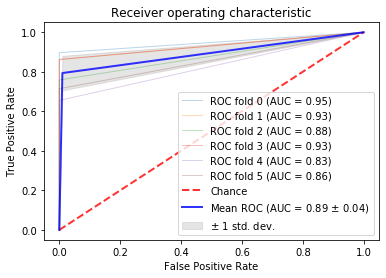

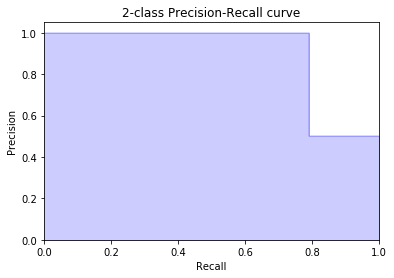

In [8]:
ANN()

In [ ]:
ANN_SMOTE()

Train on 185123 samples
Epoch 1/500
185123/185123 [==============================] - 3s 17us/sample - loss: 0.1368 - accuracy: 0.9471
Epoch 2/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0262 - accuracy: 0.9983
Epoch 3/500
185123/185123 [==============================] - 3s 18us/sample - loss: 0.0189 - accuracy: 0.9983
Epoch 4/500
185123/185123 [==============================] - 3s 16us/sample - loss: 0.0082 - accuracy: 0.9983
Epoch 5/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0066 - accuracy: 0.9983
Epoch 6/500
185123/185123 [==============================] - 2s 10us/sample - loss: 0.0062 - accuracy: 0.9983
Epoch 7/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0054 - accuracy: 0.9983
Epoch 8/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0053 - accuracy: 0.9983
Epoch 9/500
185123/185123 [==============================] - 2s 11us/sample - loss: 0.0048 - acc

185123/185123 [==============================] - 3s 18us/sample - loss: 0.0028 - accuracy: 0.9994
Epoch 72/500
185123/185123 [==============================] - 3s 18us/sample - loss: 0.0027 - accuracy: 0.9994
Epoch 73/500
185123/185123 [==============================] - 3s 15us/sample - loss: 0.0028 - accuracy: 0.9994
Epoch 74/500
185123/185123 [==============================] - 3s 15us/sample - loss: 0.0027 - accuracy: 0.9995
Epoch 75/500
185123/185123 [==============================] - 3s 16us/sample - loss: 0.0028 - accuracy: 0.9995
Epoch 76/500
185123/185123 [==============================] - 3s 17us/sample - loss: 0.0028 - accuracy: 0.9995
Epoch 77/500
185123/185123 [==============================] - 3s 16us/sample - loss: 0.0028 - accuracy: 0.9995
Epoch 78/500
185123/185123 [==============================] - 3s 15us/sample - loss: 0.0028 - accuracy: 0.9994
Epoch 79/500
185123/185123 [==============================] - 3s 14us/sample - loss: 0.0028 - accuracy: 0.9995
Epoch 80/500
1